<a href="https://colab.research.google.com/github/SophyyCC/GEOG761-Project/blob/main/christchurch_soil_moisture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import ee
ee.Authenticate()
ee.Initialize(project='disco-skyline-467321-e2')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install rasterio

In [4]:
import rasterio
from rasterio.merge import merge
from rasterio.mask import mask
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box, mapping


In [5]:
# from google.colab import files

# #I uploaded 1st SAR .tif file here
# uploaded = files.upload()

Saving AP_25343_FBD_F6300_RT1_HH.tif to AP_25343_FBD_F6300_RT1_HH.tif


In [6]:
# from google.colab import files

# #I uploaded 2nd SAR .tif file here
# uploaded = files.upload()

Saving AP_25343_FBD_F6290_RT1_HH.tif to AP_25343_FBD_F6290_RT1_HH.tif


In [5]:
hh1_path = "/content/drive/My Drive/Colab Notebooks/AP_25343_FBD_F6300_RT1_HH.tif"

import rasterio

with rasterio.open(hh1_path) as src:
    hh1 = src.read(1)  # read the first band
    hh1_profile = src.profile  # store metadata if needed

print("HH1 shape:", hh1.shape)

HH1 shape: (6276, 6675)


In [6]:
hh2_path = "/content/drive/My Drive/Colab Notebooks/AP_25343_FBD_F6290_RT1_HH.tif"

import rasterio

with rasterio.open(hh1_path) as src:
    hh2 = src.read(1)  # read the first band
    hh2_profile = src.profile  # store metadata if needed

print("HH2 shape:", hh2.shape)

HH2 shape: (6276, 6675)


In [7]:
from skimage.morphology import footprint_rectangle
from skimage.filters import rank
import numpy as np

def refined_lee(img, window_size=7):
    """
    Refined Lee speckle filter for SAR (linear backscatter)
    """
    # Convert to uint16 for rank function
    img_uint = np.clip(img*255, 0, 255).astype(np.uint8)

    # Local mean and variance using footprint_rectangle
    footprint = footprint_rectangle((window_size, window_size))
    mean_local = rank.mean(img_uint, footprint=footprint)
    var_local = rank.mean((img_uint - mean_local)**2, footprint=footprint)

    # Estimate speckle noise
    noise_var = np.mean(var_local)

    # Compute filter weights
    cu = noise_var / (var_local + 1e-12)
    filtered = mean_local + cu * (img_uint - mean_local)

    # Convert back to float (linear backscatter)
    return filtered.astype(float) / 10000

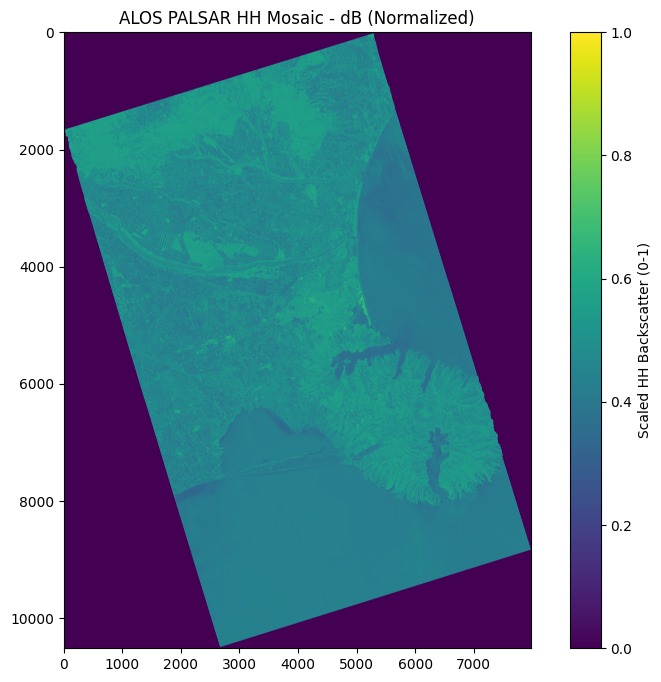

Clipped mosaic saved as HH_mosaic_clipped.tif


In [8]:
from shapely.geometry import box, mapping
import rasterio
from rasterio.merge import merge
from rasterio.mask import mask
import matplotlib.pyplot as plt
import numpy as np

hh_files = [
    "/content/drive/My Drive/Colab Notebooks/AP_25343_FBD_F6300_RT1_HH.tif",
    "/content/drive/My Drive/Colab Notebooks/AP_25343_FBD_F6290_RT1_HH.tif"
]

# -----------------------------
# Open rasters
# -----------------------------
src_files_to_mosaic = [rasterio.open(f) for f in hh_files]

# -----------------------------
# Load and mosaic rasters
# -----------------------------
mosaic, out_transform = merge(src_files_to_mosaic)

# Convert to dB
hh_linear = mosaic[0]  # get the HH band
hh_db = 10 * np.log10(np.clip(hh_linear, 1e-6, None))  # convert to dB safely
mosaic = np.array([hh_db])  # replace mosaic with dB

# -----------------------------
# Use profile from first raster
# -----------------------------
out_meta = src_files_to_mosaic[0].profile.copy()
out_meta.update({
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_transform
})

# -----------------------------
# Use mosaic bounds as AOI
# -----------------------------
minx, miny, maxx, maxy = rasterio.transform.array_bounds(
    mosaic.shape[1],
    mosaic.shape[2],
    out_transform
)
aoi_polygon_proj = box(minx, miny, maxx, maxy)
aoi_geojson = [mapping(aoi_polygon_proj)]

# -----------------------------
# Save temporary mosaic
# -----------------------------
with rasterio.open("mosaic_temp.tif", "w", **out_meta) as dest:
    dest.write(mosaic)

# -----------------------------
# Clip mosaic (will now be the same as mosaic)
# -----------------------------
with rasterio.open("mosaic_temp.tif") as src:
    clipped, clipped_transform = mask(src, aoi_geojson, crop=True)
    clipped_meta = src.profile.copy()
    clipped_meta.update({
        "height": clipped.shape[1],
        "width": clipped.shape[2],
        "transform": clipped_transform
    })

# -----------------------------
# Plot clipped mosaic
# -----------------------------
clipped_scaled = (clipped[0] - np.nanmin(clipped[0])) / (np.nanmax(clipped[0]) - np.nanmin(clipped[0]))

plt.figure(figsize=(10,8))
plt.imshow(clipped_scaled, cmap='viridis')
plt.colorbar(label='Scaled HH Backscatter (0-1)')
plt.title('ALOS PALSAR HH Mosaic - dB (Normalized)')
plt.show()

# -----------------------------
# Save clipped mosaic
# -----------------------------
out_file = "HH_mosaic_clipped.tif"
with rasterio.open(out_file, "w", **clipped_meta) as dest:
    dest.write(clipped)

print(f"Clipped mosaic saved as {out_file}")

In [9]:
for src in src_files_to_mosaic:
    print(src.name)
    print("CRS:", src.crs)
    print("Bounds:", src.bounds)

/content/drive/My Drive/Colab Notebooks/AP_25343_FBD_F6300_RT1_HH.tif
CRS: EPSG:32759
Bounds: BoundingBox(left=576137.25, bottom=5159790.25, right=659574.75, top=5238240.25)
/content/drive/My Drive/Colab Notebooks/AP_25343_FBD_F6290_RT1_HH.tif
CRS: EPSG:32759
Bounds: BoundingBox(left=591677.4375, bottom=5106851.75, right=675827.4375, top=5185401.75)


In [10]:
!pip install rasterio scikit-image numpy matplotlib


In [11]:
import numpy as np
from skimage.filters import rank
from skimage.morphology import footprint_rectangle

def refined_lee(img, window_size=7):
    """
    Approximate Refined Lee speckle filter.
    img: input backscatter (linear, not dB)
    window_size: odd integer (e.g., 7)
    """
    # Ensure valid values only
    img = np.where(np.isnan(img), 0, img)

    # Local mean and variance
    # Updated rank.mean syntax and using footprint_rectangle
    mean_local = rank.mean(img.astype(np.uint8), footprint=footprint_rectangle((window_size, window_size)))
    var_local = rank.mean((img.astype(np.uint8)-mean_local)**2, footprint=footprint_rectangle((window_size, window_size)))

    # Noise variance
    # Calculate noise variance from areas with low variance (smooth areas)
    # This is a simplification of the full Refined Lee filter
    low_var_mask = var_local < np.percentile(var_local, 10) # Use bottom 10% variance as estimate
    if np.sum(low_var_mask) > 0:
        var_noise = np.mean(var_local[low_var_mask])
    else:
        var_noise = np.mean(var_local) # Fallback if no low variance areas found

    # Lee filter formula
    # Added a small constant to the denominator to avoid division by zero
    # Using original image for filtering formula as per standard Lee filter
    # Note: A full Refined Lee uses more complex weighting
    filtered = mean_local + (var_local - var_noise)/(var_local + 1e-9) * (img - mean_local)

    # Clip values to be non-negative
    filtered = np.clip(filtered, 0, None)

    return filtered

In [12]:
import rasterio
from rasterio.windows import from_bounds
from rasterio.merge import merge
import matplotlib.pyplot as plt

filtered_tiles = []
profiles = []

for f in hh_files:
    with rasterio.open(f) as src:
        hh = src.read(1).astype(float)  # ensure float
        profile = src.profile
        profiles.append(profile)

        hh_filtered = refined_lee(hh, window_size=7)
        filtered_tiles.append(hh_filtered)

In [13]:
# Convert arrays back to raster datasets in memory
from rasterio.io import MemoryFile

datasets = []
for img, prof in zip(filtered_tiles, profiles):
    memfile = MemoryFile()
    with memfile.open(**prof) as dataset:
        dataset.write(img, 1)
    datasets.append(memfile.open())

mosaic, out_transform = merge(datasets)

out_meta = profiles[0].copy()
out_meta.update({
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_transform
})


In [18]:
# from google.colab import files

# #I uploaded land cover zip file here
# uploaded = files.upload()

Saving mfe-land-cover-database-v4-0-class-orders-SHP.zip to mfe-land-cover-database-v4-0-class-orders-SHP.zip


In [14]:
import zipfile
import os

# Step 3: Define path to the ZIP file in your Drive
zip_path = "/content/drive/My Drive/Colab Notebooks/mfe-land-cover-database-v4-0-class-orders-SHP.zip"

# Step 4: Define folder to extract the contents
extract_folder = "/content/landcover"
os.makedirs(extract_folder, exist_ok=True)

# Step 5: Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print("ZIP file extracted successfully!")

# Step 6: Check the extracted files
import os
print(os.listdir(extract_folder))

ZIP file extracted successfully!
['land-cover-database-v4-0-class-orders.shx', 'land-cover-database-v4-0-class-orders.cpg', 'land-cover-database-v4-0-class-orders.prj', 'land-cover-database-v4-0-class-orders.txt', 'land-cover-database-v4-0-class-orders.pdf', 'land-cover-database-v4-0-class-orders.shp', 'land-cover-database-v4-0-class-orders.xml', 'land-cover-database-v4-0-class-orders.dbf', 'land-cover-database-v4-0-class-orders-ISO.pdf']


In [16]:
import geopandas as gpd
import os # Import os if not already imported

# Load the landcover vector
# Define the expected folder path where the zip was extracted
extract_folder = "/content/landcover" # Make sure this matches the extraction folder in hPiHIvvLkxk_

lc_file = os.path.join(extract_folder, "land-cover-database-v4-0-class-orders.shp")
lc = gpd.read_file(lc_file)

# Check available fields
print(lc.columns)


# Keep only 2008 columns
lc_2008 = lc[['LCDB_UID', 'Class_2008', 'Name_2008', 'geometry']].copy()

# Optional: rename columns for clarity
lc_2008 = lc_2008.rename(columns={'Class_2008': 'LC_Class', 'Name_2008': 'LC_Name'})
print(lc_2008.crs)

Index(['WET_CONTEX', 'Onshore', 'LCDB_UID', 'EditDate', 'EditAuthor',
       'Class_1996', 'Class_2001', 'Class_2008', 'Class_2012', 'Name_1996',
       'Name_2001', 'Name_2008', 'Name_2012', 'LCDBtoLand', 'LCDBtoLa_1',
       'Land_cover', 'Shape_Leng', 'geometry'],
      dtype='object')
EPSG:2193


In [29]:
# from google.colab import files

# #I uploaded the DEM file here
# uploaded = files.upload()

Saving SRTM_DEM.tif to SRTM_DEM.tif


In [17]:
dem_path = "/content/drive/My Drive/Colab Notebooks/SRTM_DEM.tif"

import rasterio

with rasterio.open(dem_path) as src:
    dem = src.read(1)  # read the first band
    dem_profile = src.profile  # store metadata if needed

print("DEM shape:", dem.shape)
print("DEM CRS:", dem_profile['crs'])

DEM shape: (3515, 6191)
DEM CRS: EPSG:4326


In [18]:
import rasterio
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from osgeo import gdal
import numpy as np
import pyproj
from shapely.geometry import box, mapping
import geopandas as gpd

# -----------------------------
# Paths
# -----------------------------

dem_path = "/content/drive/My Drive/Colab Notebooks/SRTM_DEM.tif"  # update path
dem_reprojected_path = "SRTM_DEM_NZTM.tif"
dem_clipped_path = "DEM_clipped.tif"
slope_path = "DEM_slope.tif"
aspect_path = "DEM_aspect.tif"

# Define the target CRS for the DEM
dst_crs = "EPSG:2193"

# -----------------------------
# Step 1: Reproject DEM
# -----------------------------
with rasterio.open(dem_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(dem_reprojected_path, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.bilinear
            )

# -----------------------------
# Step 2: Clip DEM to AOI
# -----------------------------
# Ensure aoi_polygon_proj from cell p2pOV-ZOUfi- is available and in EPSG:32759
# Convert the AOI polygon to a GeoDataFrame and reproject
aoi_gdf = gpd.GeoDataFrame([1], geometry=[aoi_polygon_proj], crs="EPSG:32759")
aoi_gdf_reproj = aoi_gdf.to_crs(dst_crs)
aoi_geojson_reproj = [mapping(geom) for geom in aoi_gdf_reproj.geometry]

with rasterio.open(dem_reprojected_path) as src:
    dem_meta = src.meta.copy()
    # Use the reprojected AOI for masking
    dem_clipped, dem_transform = mask(src, aoi_geojson_reproj, crop=True)
    dem_clipped = dem_clipped[0]  # single band

dem_meta.update({
    "height": dem_clipped.shape[0],
    "width": dem_clipped.shape[1],
    "transform": dem_transform,
    "count": 1, # Ensure count is 1 for a single band
    "dtype": dem_clipped.dtype # Ensure dtype is correct
})

with rasterio.open(dem_clipped_path, "w", **dem_meta) as dest:
    dest.write(dem_clipped, 1)

# -----------------------------
# Step 3: Compute slope and aspect with GDAL
# -----------------------------
# You can use gdal.DEMProcessing as an alternative if richdem installation fails
gdal_dem = gdal.Open(dem_clipped_path)
gdal.DEMProcessing(slope_path, gdal_dem, "slope", format="GTiff", slopeFormat="degree")
gdal.DEMProcessing(aspect_path, gdal_dem, "aspect", format="GTiff")

print("DEM reprojected, clipped, and slope/aspect rasters saved.")

/usr/local/lib/python3.12/dist-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


DEM reprojected, clipped, and slope/aspect rasters saved.


In [19]:
import rasterio


In [52]:
# from google.colab import files

# #I uploaded the MODIS data here
# uploaded = files.upload()

Saving MOD13Q1.A2010289.h30v13.061.2021176120403.hdf to MOD13Q1.A2010289.h30v13.061.2021176120403.hdf


In [28]:
import rasterio
from rasterio.merge import merge
from rasterio.mask import mask
from shapely.geometry import box, mapping
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
from osgeo import gdal

# Mount Google Drive
drive.mount('/content/drive')

# Full path to the HDF
modis_hdf = "/content/drive/My Drive/Colab Notebooks/MOD13Q1.A2010289.h30v13.061.2021176120403.hdf"

# Open HDF
dataset = gdal.Open(modis_hdf, gdal.GA_ReadOnly)
if dataset is None:
    print("Could not open HDF file.")
else:
    print("HDF file opened successfully!")
    subdatasets = dataset.GetSubDatasets()
    print("Available subdatasets:")
    for sd in subdatasets:
        print(sd[0])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
HDF file opened successfully!
Available subdatasets:
HDF4_EOS:EOS_GRID:"/content/drive/My Drive/Colab Notebooks/MOD13Q1.A2010289.h30v13.061.2021176120403.hdf":MODIS_Grid_16DAY_250m_500m_VI:"250m 16 days NDVI"
HDF4_EOS:EOS_GRID:"/content/drive/My Drive/Colab Notebooks/MOD13Q1.A2010289.h30v13.061.2021176120403.hdf":MODIS_Grid_16DAY_250m_500m_VI:"250m 16 days EVI"
HDF4_EOS:EOS_GRID:"/content/drive/My Drive/Colab Notebooks/MOD13Q1.A2010289.h30v13.061.2021176120403.hdf":MODIS_Grid_16DAY_250m_500m_VI:"250m 16 days VI Quality"
HDF4_EOS:EOS_GRID:"/content/drive/My Drive/Colab Notebooks/MOD13Q1.A2010289.h30v13.061.2021176120403.hdf":MODIS_Grid_16DAY_250m_500m_VI:"250m 16 days red reflectance"
HDF4_EOS:EOS_GRID:"/content/drive/My Drive/Colab Notebooks/MOD13Q1.A2010289.h30v13.061.2021176120403.hdf":MODIS_Grid_16DAY_250m_500m_VI:"250m 16 days NIR reflectance"
HDF4_EOS:EO

In [29]:
from osgeo import gdal
import rasterio
import numpy as np # Import numpy

modis_hdf = "MOD13Q1.A2010289.h30v13.061.2021176120403.hdf"
dataset = gdal.Open(modis_hdf, gdal.GA_ReadOnly)
if dataset is None:
    print("Could not open HDF file.")
else:
    subdatasets = dataset.GetSubDatasets()
    print("Available subdatasets:")
    for sd in subdatasets:
        print(sd[0])

    # Open NDVI layer using gdal
    ndvi_path = subdatasets[0][0]  # Get the path string
    ndvi_dataset = gdal.Open(ndvi_path, gdal.GA_ReadOnly)

    if ndvi_dataset is None:
        print(f"Could not open NDVI subdataset: {ndvi_path}")
    else:
        # Read the NDVI data as a numpy array
        ndvi = ndvi_dataset.ReadAsArray()
        print("\nNDVI data read successfully using gdal.")

        # You can now work with the 'ndvi' numpy array
        # If you need to use rasterio functions later, you might need to save
        # this array as a temporary GeoTIFF or similar format that rasterio supports.
        # Example:
        # out_tiff = "ndvi_temp.tif"
        # driver = gdal.GetDriverByName("GTiff")
        # out_dataset = driver.CreateCopy(out_tiff, ndvi_dataset, 0)
        # out_dataset = None # Close the dataset
        # print(f"NDVI saved as temporary GeoTIFF: {out_tiff}")

        # Close the gdal datasets
        ndvi_dataset = None
        dataset = None

        #multiply to account for MODIS scale factor
        ndvi = ndvi * 0.0001


Could not open HDF file.


In [11]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Step 1: Open NDVI file (GeoTIFF or subdataset)
src_ndvi = rasterio.open("path_to_your_modis_ndvi.tif")

# Step 2: Define target CRS (NZTM)
dst_crs = "EPSG:2193"

transform, width, height = calculate_default_transform(
    src_ndvi.crs, dst_crs, src_ndvi.width, src_ndvi.height, *src_ndvi.bounds)

kwargs = src_ndvi.meta.copy()
kwargs.update({
    'crs': dst_crs,
    'transform': transform,
    'width': width,
    'height': height
})

# Step 3: Reproject into NZTM
with rasterio.open("ndvi_reprojected.tif", "w", **kwargs) as dst:
    for i in range(1, src_ndvi.count + 1):
        reproject(
            source=rasterio.band(src_ndvi, i),
            destination=rasterio.band(dst, i),
            src_transform=src_ndvi.transform,
            src_crs=src_ndvi.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.bilinear
        )


RasterioIOError: path_to_your_modis_ndvi.tif: No such file or directory

In [60]:
from google.colab import files

#I uploaded the CCI data here
uploaded = files.upload()

Saving ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-20101027000000-fv09.1.nc to ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-20101027000000-fv09.1.nc


In [62]:
import xarray as xr
ds = xr.open_dataset("ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-20101027000000-fv09.1.nc")
print(ds)

<xarray.Dataset> Size: 29MB
Dimensions:         (time: 1, lat: 720, lon: 1440)
Coordinates:
  * time            (time) datetime64[ns] 8B 2010-10-27
  * lat             (lat) float32 3kB 89.88 89.62 89.38 ... -89.38 -89.62 -89.88
  * lon             (lon) float32 6kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    sm              (time, lat, lon) float32 4MB ...
    sm_uncertainty  (time, lat, lon) float32 4MB ...
    flag            (time, lat, lon) float32 4MB ...
    freqbandID      (time, lat, lon) int16 2MB ...
    dnflag          (time, lat, lon) int8 1MB ...
    mode            (time, lat, lon) int8 1MB ...
    sensor          (time, lat, lon) int32 4MB ...
    t0              (time, lat, lon) datetime64[ns] 8MB ...
Attributes: (12/44)
    title:                        ESA CCI Surface Soil Moisture COMBINED acti...
    institution:                  TU Wien (AUT); VanderSat B.V. (NL); Planet ...
    contact:                      cci_sm_contact@eodc.eu
    source:   

In [ ]:
soil_moisture = ds['sm'].values  # Example variable name: check ds
out_tiff = "cci_soilm.tif"

with rasterio.open("HH_mosaic_clipped.tif") as ref:
    ref_profile = ref.profile
    ref_transform = ref.transform
    ref_bounds = ref.bounds

from rasterio.warp import reproject, Resampling

with rasterio.open("cci_temp.tif") as src, rasterio.open("HH_mosaic_clipped.tif") as ref:
    cci_aligned = np.empty((ref.height, ref.width), dtype=np.float32)

    reproject(
        source=rasterio.band(src, 1),
        destination=cci_aligned,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=ref.transform,
        dst_crs=ref.crs,
        resampling=Resampling.bilinear
    )

ref_profile.update(dtype=rasterio.float32, count=1)

with rasterio.open(out_tiff, "w", **ref_profile) as dst:
    dst.write(cci_aligned, 1)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Stack raster predictors
predictors = np.stack([hh_filtered_mosaic, dem_clipped, slope, aspect, ndvi], axis=-1)

# Flatten predictors
n_rows, n_cols, n_features = predictors.shape
X = predictors.reshape(n_rows * n_cols, n_features)

# Flatten soil moisture raster (CCI data) as target
y = soil_moisture_clipped.reshape(-1)   # <-- your CCI data must be clipped & aligned

# Mask NaNs
mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
X_clean = X[mask]
y_clean = y[mask]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.3, random_state=42)

# Random Forest **Regressor**
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

# Train
rf.fit(X_train, y_train)

# Evaluate
y_pred_test = rf.predict(X_test)
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("R²:", r2_score(y_test, y_pred_test))

# Predict full raster
predictions_full = np.zeros(X.shape[0], dtype=float)
predictions_full[mask] = rf.predict(X_clean)

# Reshape to raster
pred_raster = predictions_full.reshape(n_rows, n_cols)


In [ ]:

# #old random forest model code - I am no longer using this!
# #stack raster predictors
# predictors = np.stack([hh_filtered_mosaic, dem_clipped, slope, aspect, ndvi], axis=-1)
# print(predictors.shape)  # (rows, cols, num_features)

# #flatten to 2D
# n_rows, n_cols, n_features = predictors.shape
# X = predictors.reshape(n_rows * n_cols, n_features)

# #mask NAs
# mask = ~np.isnan(X).any(axis=1)  # keep rows without NaN
# X_clean = X[mask]
# y_clean = y[mask]

# #Train RF model
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, confusion_matrix

# # Split data
# X_train, X_test, y_train, y_test = train_test_split(
#     X_clean, y_clean, test_size=0.3, random_state=42
# )

# # Create model
# rf = RandomForestClassifier(
#     n_estimators=100,  # number of trees
#     max_depth=None,    # or set to prevent overfitting
#     random_state=42,
#     n_jobs=-1          # use all cores
# )

# # Train
# rf.fit(X_train, y_train)

# # Evaluate
# y_pred = rf.predict(X_test)
# print(classification_report(y_test, y_pred))

# #predict full raster
# full_mask = ~np.isnan(X).any(axis=1)
# X_full = X[full_mask]

# predictions = np.zeros(X.shape[0], dtype=int)
# predictions[full_mask] = rf.predict(X_full)

# # Reshape back to raster shape
# pred_raster = predictions.reshape(n_rows, n_cols)